1. Veri Yükleme ve İlk İnceleme

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

# Veriyi yükleme
df = pd.read_csv('cleaned_health_data.csv')

# İlk 5 satırı göster
print(df.head())

# Veri seti bilgileri
print("\nVeri seti bilgileri:")
print(df.info())

# Temel istatistikler
print("\nTemel istatistikler:")
print(df.describe())

   survey_code   age  gender  height  weight    bmi  waist_size  \
0          1.0  56.0       1  173.42   56.89  18.92       72.17   
1          2.0  69.0       0  163.21   97.80  36.72       85.60   
2          3.0  46.0       1  177.28   80.69  25.67       90.30   
3          4.0  32.0       0  172.10   63.14  21.32      100.50   
4          5.0  60.0       0  163.61   40.00  14.94       69.02   

   blood_pressure  heart_rate  cholesterol  ...  device_usage  \
0          118.26       60.75       214.58  ...             0   
1          117.92       66.46       115.79  ...             2   
2          123.07       76.04       138.13  ...             0   
3          148.17       68.78       203.02  ...             1   
4          150.61       92.34       200.41  ...             1   

   healthcare_access  insurance  sunlight_exposure  meals_per_day  \
0                  2          0                  0            5.0   
1                  1          0                  0            5.0   

2. Veri Temizleme ve Ön İşleme

In [ ]:
# Eksik veri kontrolü
print("\nEksik veri sayısı:")
print(df.isnull().sum())

# Kategorik değişkenleri kontrol etme
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("\nKategorik değişkenler:", categorical_cols)

# Sayısal değişkenleri kontrol etme
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nSayısal değişkenler:", numeric_cols)

# Gereksiz sütunları kaldırma (eğer varsa)
df = df.drop(['survey_code'], axis=1)  # survey_code sütunu gereksiz görünüyor

# BMI kategorileri oluşturma
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(bmi_category)

# Kan basıncı kategorileri
def bp_category(systolic):
    if systolic < 120:
        return 'Normal'
    elif 120 <= systolic < 130:
        return 'Elevated'
    elif 130 <= systolic < 140:
        return 'High (Stage 1)'
    elif 140 <= systolic < 180:
        return 'High (Stage 2)'
    else:
        return 'Hypertensive Crisis'

df['bp_category'] = df['blood_pressure'].apply(bp_category)


Eksik veri sayısı:
survey_code                0
age                        0
gender                     0
height                     0
weight                     0
bmi                        0
waist_size                 0
blood_pressure             0
heart_rate                 0
cholesterol                0
glucose                    0
insulin                    0
sleep_hours                0
sleep_quality              0
work_hours                 0
physical_activity          0
daily_steps                0
calorie_intake             0
sugar_intake               0
alcohol_consumption        0
smoking_level              0
water_intake               0
screen_time                0
stress_level               0
mental_health_score        0
mental_health_support      0
education_level            0
job_type                   0
occupation                 0
income                     0
diet_type                  0
exercise_type              0
device_usage               0
healthcare_access      

3. Veri Görselleştirme

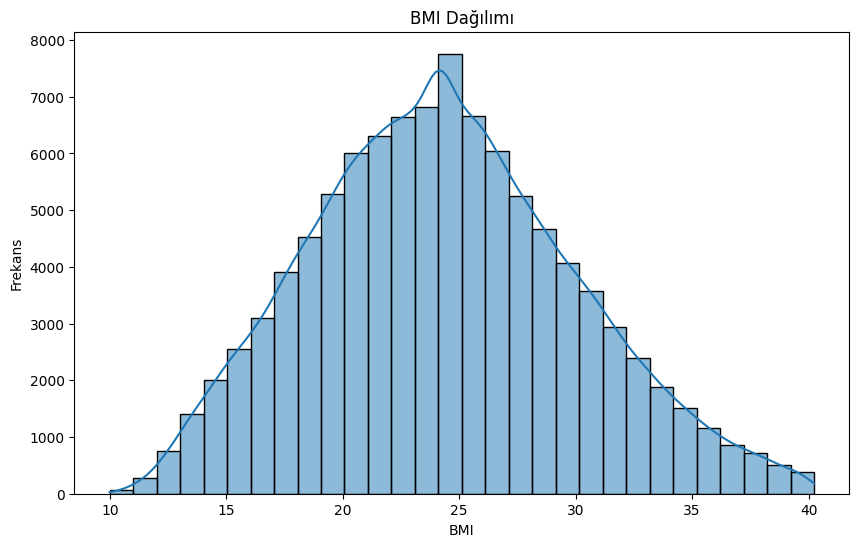

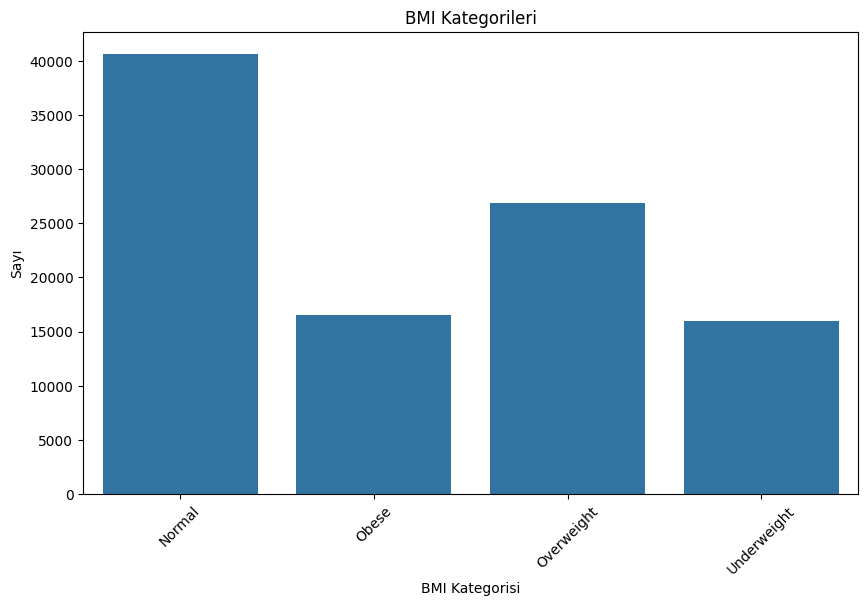

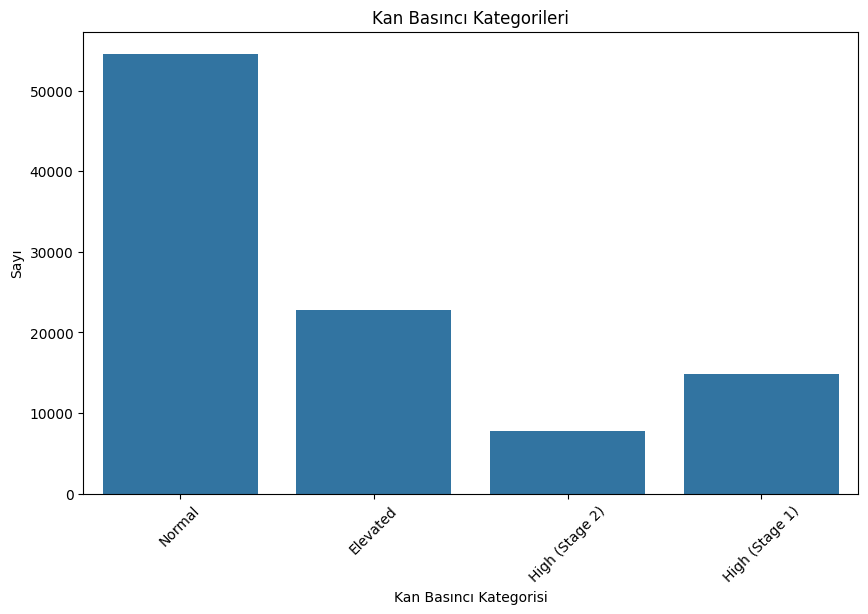

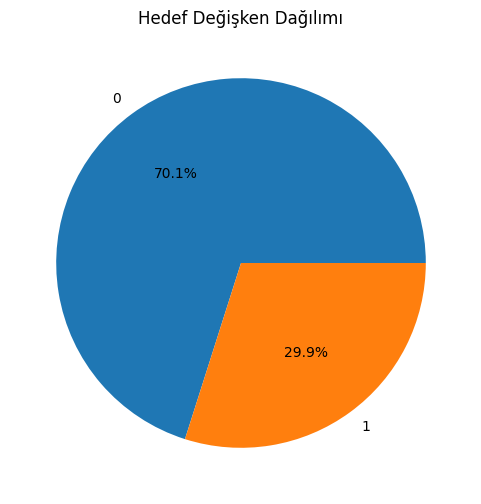

In [ ]:
# BMI dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], kde=True, bins=30)
plt.title('BMI Dağılımı')
plt.xlabel('BMI')
plt.ylabel('Frekans')
plt.show()

# BMI kategorilerine göre dağılım
plt.figure(figsize=(10, 6))
sns.countplot(x='bmi_category', data=df)
plt.title('BMI Kategorileri')
plt.xlabel('BMI Kategorisi')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.show()

# Kan basıncı kategorileri
plt.figure(figsize=(10, 6))
sns.countplot(x='bp_category', data=df)
plt.title('Kan Basıncı Kategorileri')
plt.xlabel('Kan Basıncı Kategorisi')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.show()

# Hedef değişken dağılımı
plt.figure(figsize=(6, 6))
df['target'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Hedef Değişken Dağılımı')
plt.ylabel('')
plt.show()

4. Özellik Mühendisliği

In [ ]:
# Yeni özellikler oluşturma
df['physical_activity_level'] = pd.cut(df['physical_activity'],
                                     bins=[-1, 1, 3, 10],
                                     labels=['Low', 'Moderate', 'High'])

df['sleep_quality_level'] = pd.cut(df['sleep_quality'],
                                 bins=[-1, 3, 7, 10],
                                 labels=['Poor', 'Average', 'Good'])

# Kategorik değişkenleri sayısallaştırma
df = pd.get_dummies(df, columns=['gender', 'bmi_category', 'bp_category',
                                'physical_activity_level', 'sleep_quality_level'],
                   drop_first=True)

# Ölçeklendirme için sayısal sütunları seçme
numeric_features = ['age', 'height', 'weight', 'bmi', 'waist_size', 'blood_pressure',
                   'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours',
                   'work_hours', 'daily_steps', 'calorie_intake', 'sugar_intake',
                   'water_intake', 'screen_time', 'stress_level', 'mental_health_score']

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

5. Özellik Seçimi

In [ ]:
# Hedef ve özellikleri ayırma
X = df.drop('target', axis=1)
y = df['target']

# En iyi özellikleri seçme
selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Seçilen özelliklerin isimlerini al
selected_features = X.columns[selector.get_support()]

print("\nSeçilen en iyi 20 özellik:")
print(selected_features)

# Veriyi seçilen özelliklerle güncelle
X = X[selected_features]


Seçilen en iyi 20 özellik:
Index(['age', 'weight', 'bmi', 'blood_pressure', 'cholesterol', 'sleep_hours',
       'sleep_quality', 'work_hours', 'daily_steps', 'alcohol_consumption',
       'water_intake', 'job_type', 'exercise_type', 'healthcare_access',
       'meals_per_day', 'bmi_category_Overweight',
       'bp_category_High (Stage 1)', 'bp_category_Normal',
       'physical_activity_level_Moderate', 'physical_activity_level_High'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [48 49] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


6. Model Oluşturma ve Eğitim


Model Performansı:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     21023
           1       0.31      0.00      0.00      8977

    accuracy                           0.70     30000
   macro avg       0.51      0.50      0.41     30000
weighted avg       0.58      0.70      0.58     30000

Doğruluk: 0.7003666666666667


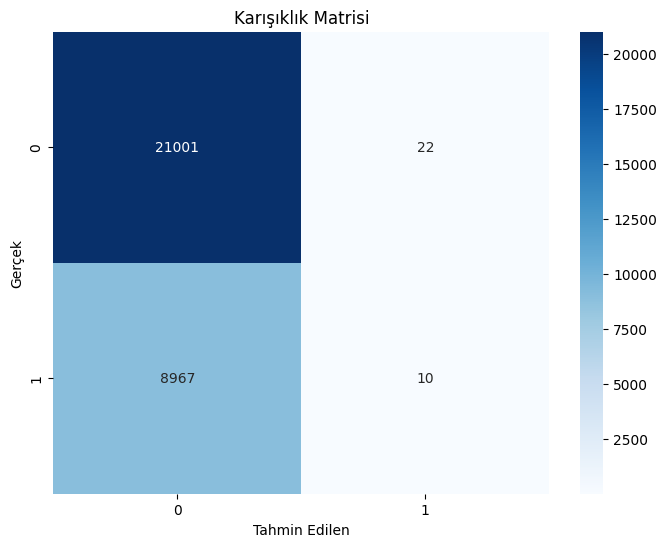

In [ ]:
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest modeli oluşturma ve eğitme
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahminler yapma
y_pred = rf_model.predict(X_test)

# Model performansını değerlendirme
print("\nModel Performansı:")
print(classification_report(y_test, y_pred))
print("Doğruluk:", accuracy_score(y_test, y_pred))

# Karışıklık matrisi
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

8. Modeli Kaydetme

In [ ]:
import joblib

# Modeli ve scaler'ı kaydetme
joblib.dump(rf_model, 'health_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'feature_selector.pkl')

# Seçilen özellikleri kaydetme
with open('selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")

9. Otomasyon Senaryosu

In [ ]:
def predict_health_risk(new_data):
    """
    Yeni veri üzerinde sağlık riski tahmini yapar

    Args:
        new_data (dict): Kullanıcıdan alınan sağlık verileri

    Returns:
        dict: Tahmin sonuçları ve risk faktörleri
    """
    # Model ve diğer nesneleri yükle
    model = joblib.load('health_risk_model.pkl')
    scaler = joblib.load('scaler.pkl')
    selector = joblib.load('feature_selector.pkl')

    with open('selected_features.txt', 'r') as f:
        selected_features = [line.strip() for line in f]

    # Yeni veriyi DataFrame'e çevir
    new_df = pd.DataFrame([new_data])

    # Ön işleme adımları
    # BMI hesapla (eğer verilmediyse)
    if 'bmi' not in new_data:
        new_df['bmi'] = new_df['weight'] / ((new_df['height']/100) ** 2)

    # BMI kategorisi
    new_df['bmi_category'] = new_df['bmi'].apply(bmi_category)

    # Kan basıncı kategorisi
    if 'blood_pressure' in new_data:
        new_df['bp_category'] = new_df['blood_pressure'].apply(bp_category)

    # Fiziksel aktivite seviyesi
    if 'physical_activity' in new_data:
        new_df['physical_activity_level'] = pd.cut(new_df['physical_activity'],
                                                 bins=[-1, 1, 3, 10],
                                                 labels=['Low', 'Moderate', 'High'])

    # One-hot encoding
    new_df = pd.get_dummies(new_df)

    # Eksik sütunları ekle (eğitim verisindeki tüm sütunlar olmalı)
    for col in selected_features:
        if col not in new_df.columns:
            new_df[col] = 0

    # Sadece seçilen özellikleri seç
    new_df = new_df[selected_features]

    # Tahmin yap
    prediction = model.predict(new_df)
    proba = model.predict_proba(new_df)

    # Sonuçları hazırla
    result = {
        'prediction': int(prediction[0]),
        'probability': float(proba[0][1]),
        'risk_factors': {}
    }

    # Risk faktörlerini belirle
    feature_importances = model.feature_importances_
    top_features_idx = np.argsort(feature_importances)[-3:]  # En önemli 3 özellik
    for idx in top_features_idx:
        feature_name = selected_features[idx]
        result['risk_factors'][feature_name] = {
            'value': new_df[feature_name].values[0],
            'importance': feature_importances[idx]
        }

    return result

# Örnek kullanım
sample_data = {
    'age': 45,
    'gender': 1,
    'height': 175,
    'weight': 80,
    'blood_pressure': 130,
    'cholesterol': 200,
    'glucose': 100,
    'physical_activity': 2.5,
    'sleep_hours': 7,
    'stress_level': 5
}

result = predict_health_risk(sample_data)
print("\nTahmin Sonucu:")
print(result)


Tahmin Sonucu:
{'prediction': 0, 'probability': 0.45, 'risk_factors': {'daily_steps': {'value': np.int64(0), 'importance': np.float64(0.09179406963627681)}, 'work_hours': {'value': np.int64(0), 'importance': np.float64(0.09186244483220055)}, 'cholesterol': {'value': np.int64(200), 'importance': np.float64(0.0945920314138813)}}}


# Model Geliştirme Otomasyonu (Model Pipeline)

Veri Ön İşleme Pipeline'ı

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


Eksik Veri & Aykırı Değer Kontrolünü Otomatikleştir

In [ ]:
def check_data(df):
    missing = df.isnull().sum()
    outliers = df[(df < df.quantile(0.01)) | (df > df.quantile(0.99))].count()
    return missing, outliers


# Model Değerlendirme Otomasyonu

Otomatik Model Karşılaştırıcı

In [ ]:
from sklearn.model_selection import cross_val_score

def try_models(X, y):
    models = {
        "LogReg": LogisticRegression(),
        "RF": RandomForestClassifier(),
        "SVC": SVC(),
    }

    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=5)
        print(f"{name}: Ortalama Doğruluk = {scores.mean():.2f}")


Threshold Tuning (eşik değeriyle oyna)

In [ ]:
# Modeli bu hücre içinde yeniden oluşturup eğitin
# Bu, başka bir yerde model değişkeninin üzerine yazılmasını önler
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_probs = model.predict_proba(X_test)[:, 1]
y_custom = (y_probs > 0.6).astype(int)  # Eşik değerini değiştirerek risk seviyesi belirlenebilir

# İsteğe bağlı: Yeni eşik değeri ile performans metriklerini kontrol etme
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"\nPerformance with threshold 0.6:")
print("Accuracy:", accuracy_score(y_test, y_custom))
print("\nClassification Report:\n", classification_report(y_test, y_custom))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_custom))


Performance with threshold 0.6:
Accuracy: 0.7007666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82     21023
           1       0.00      0.00      0.00      8977

    accuracy                           0.70     30000
   macro avg       0.35      0.50      0.41     30000
weighted avg       0.49      0.70      0.58     30000


Confusion Matrix:
 [[21023     0]
 [ 8977     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Veri Güncelleme ve İzleme Otomasyonu

Yeni Veri Geldikçe Güncelleme (Retraining)

In [ ]:
import os

def load_and_update_model():
    if os.path.exists("new_data.csv"):
        new_df = pd.read_csv("new_data.csv")
        # Modeli yeniden eğit
        # pipeline.fit(...)


 Model Performans Log Kaydı

In [ ]:
import datetime

log_df = pd.DataFrame({
    "timestamp": [datetime.datetime.now()],
    "accuracy": [accuracy_score(y_test, y_pred)],
    "model": ["RandomForest"]
})

log_df.to_csv("model_logs.csv", mode='a', index=False, header=not os.path.exists("model_logs.csv"))


Otomatik Hiparparametre Optimizasyonu
GridSearchCV / RandomizedSearchCV: Farklı model parametrelerini otomatik deneyerek en iyi kombinasyonu bulabilirsiniz.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("En iyi parametreler:", grid_search.best_params_)


KeyboardInterrupt: 

Otomatik Özellik Seçimi ve Mühendisliği
Feature Selection: SelectKBest, RFE gibi yöntemlerle en önemli özellikleri otomatik seçmek, model performansını artırabilir.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning:

Features [48 49] are constant.

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning:

invalid value encountered in divide



Model İzleme ve Otomatik Güncelleme
Performans Loglama: Modelin her eğitimi sonrası metriklerini, zaman damgalarıyla kaydedebilirsin. Bu loglar, model performansında düşüş olup olmadığını kontrol etmeni sağlar.



In [ ]:
import datetime, os

def log_model_performance(accuracy, model_name):
    log_entry = f"{datetime.datetime.now()}, {model_name}, {accuracy}\n"
    with open("model_performance_log.csv", "a") as file:
        file.write(log_entry)

log_model_performance(accuracy_score(y_test, y_pred), "RandomForest")


Model Yorumlanabilirliği ve Şeffaflık
SHAP veya LIME Entegrasyonu: Modelin tahminlerini açıklamak ve kullanıcıya hangi özelliklerin daha etkili olduğunu göstermek için SHAP veya LIME gibi araçları entegre edebilirsin.

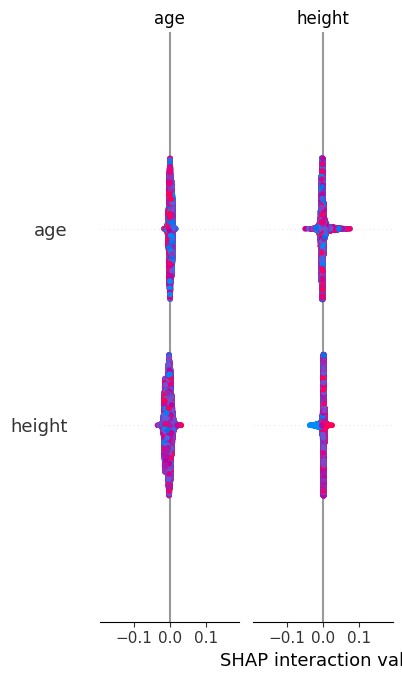

In [ ]:
import shap
explainer = shap.TreeExplainer(best_model.named_steps['model'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


 Model Başarı Karşılaştırma Grafiği

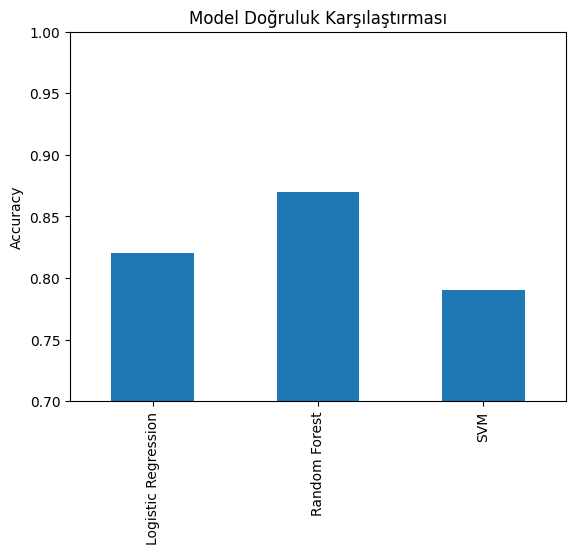

In [ ]:
results = {
    "Logistic Regression": 0.82,
    "Random Forest": 0.87,
    "SVM": 0.79
}

pd.Series(results).plot(kind="bar", title="Model Doğruluk Karşılaştırması")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.show()


Feature Importance (Özellik Önem Derecesi)

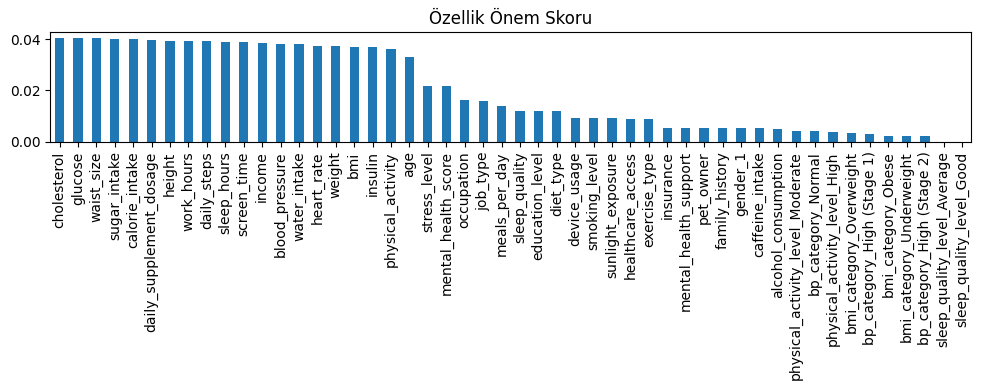

In [ ]:
import pandas as pd

importances = model.feature_importances_
features = X.columns
importance_df = pd.Series(importances, index=features).sort_values(ascending=False)

importance_df.plot(kind='bar', figsize=(10, 4), title='Özellik Önem Skoru')
plt.tight_layout()
plt.show()


In [4]:
from flask import Flask, render_template, request, jsonify
import subprocess
import os

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/execute', methods=['POST'])
def execute_powershell():
    command = request.form.get('command')
    try:
        # PowerShell komutunu çalıştır
        result = subprocess.run(["powershell", "-Command", command],
                              capture_output=True,
                              text=True,
                              timeout=30)

        output = result.stdout if result.stdout else result.stderr
        return jsonify({
            'success': result.returncode == 0,
            'output': output,
            'error': result.stderr if result.returncode != 0 else None
        })
    except subprocess.TimeoutExpired:
        return jsonify({
            'success': False,
            'output': '',
            'error': 'Komut zaman aşımına uğradı (30 saniye)'
        })
    except Exception as e:
        return jsonify({
            'success': False,
            'output': '',
            'error': str(e)
        })

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
